# Clip the `hyras` dataset for one catchment and year

This is a long text explainging what this notebook does in detail

## Parameters


This notebook is supposed to be run with `papermill`. These are the parameters, that can be changed from outside the notebook, using papermill.
Values in here reflect default values and are not meant to be changed directly.

In [1]:
# parameters for this catchment
catchment_id = 'DEE11200'
variable = 'pr'
local_cache = None

# some settings to control the processing
WITH_PAPERMILL = False
MANUAL_RUN = False

# general settings
target_bucket = 'camels_output_data'
local_hyras_cache = '../hyras_cache'
notebook_bucket = 'camels_notebooks'
catchments_path = './merit_hydro_catchments.gpkg'
base_url = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de"

## Preamble

This part import necessary packages and derives some needed parameters from the supplied parameters.

In [2]:
import tempfile
from datetime import datetime as dt
from tqdm import tqdm
from pathlib import Path

from dotenv import load_dotenv
import httpx
import duckdb
import xarray as xr
import geopandas as gpd
from geocube.api.core import make_geocube

load_dotenv()

True

In [3]:
# handle the local cache path
if local_cache is None:
    local_cache = Path.cwd() / catchment_id
else:
    local_cache = Path(local_cache)

if not local_cache.exists():
    local_cache.mkdir(parents=True, exist_ok=True)

This notebook is intended to be run by `papermill` to ensure, that it ran automatically with transparent setting of parameters.
As we expect some runs to fail on specific catchments, it is also possible to inspect these notebooks and run them by hand. To do so, you
need to set the `MANUAL_RUN` flag to `True`, otherwise, the next cell will raise an exception and create an error file.

If you need to postprocess a specific version of this notebook, you have to indicate the changes you did in the next cell, by supplying a description, which will be stored along with the processed files.

In [4]:
# this is the error handler, to abort the execution of the notebook

error_msg = f"""The execution of the clip_catchment_from_hyras.ipynb has been cancelled on {dt.utcnow()} UTC.
The reason is, that the notebook was not executed with papermill, and/or the parameter WITH_PAPERMILL was not set to `True` by papermill.
This is necessary to ensure, that all HYRAS files where processed in exactly the same way.
By this we state clear data and processing provenance for the CAMELS-DE dataset.

In case you tried to debug this notebook, or fix specificities about some catchments, you can set the parameter MANUAL_RUN to `True` 
and execute the notebook again. In that case it is abosulely necessary to update the notebook to reflect the changes you made.
In addition, you should explain all changes in the notebook itself, and upload it to the other notebooks.

DEBUG
-----
catchment_id: {catchment_id}
variable: {variable}
catchments_path: {catchments_path}
local_cache: {local_cache}

HYRAS
-----
base_url: {base_url}
target_bucket: {target_bucket}
notebook_bucket: {notebook_bucket}
"""
if not WITH_PAPERMILL and not MANUAL_RUN:
    # raise the error, to let papermill handle it
    raise RuntimeError(error_msg)

RuntimeError: The execution of the clip_catchment_from_hyras.ipynb has been cancelled on 2024-01-12 08:37:13.468103 UTC.
The reason is, that the notebook was not executed with papermill, and/or the parameter WITH_PAPERMILL was not set to `True` by papermill.
This is necessary to ensure, that all HYRAS files where processed in exactly the same way.
By this we state clear data and processing provenance for the CAMELS-DE dataset.

In case you tried to debug this notebook, or fix specificities about some catchments, you can set the parameter MANUAL_RUN to `True` 
and execute the notebook again. In that case it is abosulely necessary to update the notebook to reflect the changes you made.
In addition, you should explain all changes in the notebook itself, and upload it to the other notebooks.

DEBUG
-----
catchment_id: DEE11200
variable: pr
catchments_path: ./merit_hydro_catchments.gpkg
local_cache: /home/alexd/Projekte/CAMELS/Github/clipper/src/DEE11200

HYRAS
-----
base_url: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de
target_bucket: camels_output_data
notebook_bucket: camels_notebooks


Define the necessary functions to download the hyras dataset and to download the catchments, if not supplied locally.
Outside of this notebook, you can use the `db.DuckProcessor`, which can do all of that and be configured directly, or by environment variables.
These cells re-define the needed functionality to make the notebook self-contained. You do not need `db.DuckProcessor` to run it.

In [5]:
VAR_MAP = {
    'pr': 'precipitation',
    'hurs': 'humidity',
    'rsds': 'radiation_global',
    'tas': 'air_temperature_mean',
    'tasmax': 'air_temperature_max',
    'tasmin': 'air_temperature_min'
}

def download_hyras(variable: str, year: int) -> str:
    # build the filename 
    filename = f"{variable}_hyras_{1 if variable in ('pr') else 5}_{year}_v{3 if variable == 'rsds' else 5}-0_de.nc"
    
    # check if that file exists in the local cache
    path = Path(local_hyras_cache) / filename
    if path.exists():
        return str(path)

    # if not, download from DWD open data server
    url = f"{base_url}/{VAR_MAP[variable]}/{filename}"

    # download
    response = httpx.get(url)

    # if we successfully downloaded the file, hooray
    if response.status_code == 200:
        with open(path, 'wb') as f:
            f.write(response.content)
        
        # return
        return str(path)

    raise FileNotFoundError(f"Failed to load {variable} for {year}. (Tested: {url}).")


In [6]:
# read the catchments
catchments = gpd.read_file(catchments_path)

# add an numerical object id to the catchments
catchments['oid'] = range(len(catchments))

# filter for the requested catchment and reproject to hyras CRS 
catchment = catchments.where(catchments.id == catchment_id).dropna().to_crs('epsg:3034')

catchment

,id,name,result,area_calc,area_reported,geometry,oid
672,DEE11200,Löben,High Res,3370.0,4332.0,"POLYGON ((4210400.561 2772027.790, 4210400.561...",672.0


Using resolution (-500, 500)


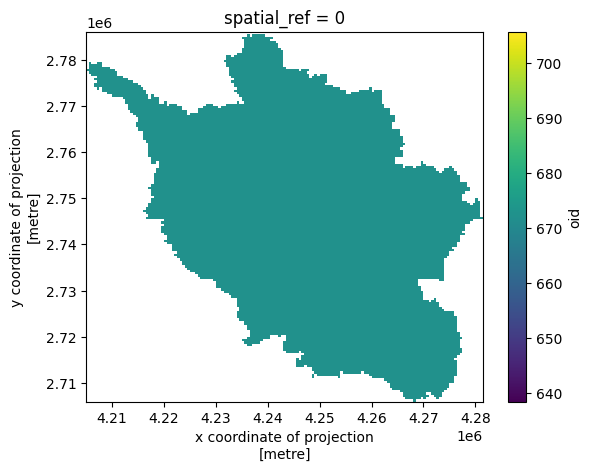

In [7]:
# build a geocube for that catchment with the correct grid resolution
resolution = (-500, 500) if variable == 'pr' else (-2500, 2500)
print(f'Using resolution {resolution}')

cube = make_geocube(
    vector_data=catchment,
    measurements=['oid'],
    resolution=resolution
)

# plot a preview
cube.oid.plot()

# save the parquet file
cube.to_dataframe().reset_index()[['x', 'y', 'oid']].dropna().to_parquet(f'{catchment_id}.parquet')

In [8]:
# generate the Bounding box
xmin = int(cube.x.min().values)
xmax = int(cube.x.max().values)
ymin = int(cube.y.min().values)
ymax = int(cube.y.max().values)

print(f"BBOX ({xmin}, {xmax}, {ymin}, {ymax})")

BBOX (4205250, 4281250, 2706250, 2785750)


## duckdb clip

In [9]:
# prepare the query
SQL = f"""
insert into {variable}
with tmp as (
    select 
        time, 
        (x - {resolution[1]}, y - {resolution[1]}, x + {resolution[1]}, y + {resolution[1]})::box_2d as cell, 
        {variable}
    from '{variable}.parquet'
)
select * from tmp where exists (select 1 from catchment where st_within(point, cell));
"""

print(SQL)


insert into pr
with tmp as (
    select 
        time, 
        (x - 500, y - 500, x + 500, y + 500)::box_2d as cell, 
        pr
    from 'pr.parquet'
)
select * from tmp where exists (select 1 from catchment where st_within(point, cell));



In [10]:
#
# loop through each year
warns = []
for year in tqdm(range(1950, 2024)):
    # download the file if needed
    try:
        nc_path = download_hyras(variable, year)
    except Exception as e:
        warns.append(str(e))
        print(str(e))
        continue
    
    # open the file
    da = xr.open_dataset(nc_path)[variable]
    ds = xr.Dataset({variable: da})

    # transform to long-format parquet
    df = ds.to_dataframe().reset_index()[['time', 'x', 'y', variable]].dropna()
    df.where((df.x >= xmin) & (df.x <= xmax) & (df.y >= ymin) & (df.y <= ymax)).dropna().to_parquet(f"{variable}.parquet")

    # next create the duckdb database
    with duckdb.connect(str(local_cache / f'{catchment_id}.db')) as con:
        # install the spatial extension
        con.install_extension('spatial')
        con.load_extension('spatial')
        con.execute('SET threads=8;')

        # load the catchment
        con.execute(f"CREATE TABLE IF NOT EXISTS catchment AS SELECT oid, st_point(x, y) AS point FROM '{catchment_id}.parquet';")

        # do the magic
        con.execute(f"CREATE TABLE IF NOT EXISTS {variable} (time timestamp, cell box_2d, {variable} double);")
        con.execute(SQL)
    
    # for now we break
    # break

print('DONE.')
if len(warns) > 0:
    print(f'Had {len(warns)} warnings:')
    for w in warns:
        print(f' - {w}')

  3%|▎         | 2/74 [00:00<00:17,  4.05it/s]

Failed to load pr for 1950. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1950_v5-0_de.nc).
Failed to load pr for 1951. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1951_v5-0_de.nc).


  5%|▌         | 4/74 [00:00<00:13,  5.09it/s]

Failed to load pr for 1952. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1952_v5-0_de.nc).
Failed to load pr for 1953. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1953_v5-0_de.nc).


  8%|▊         | 6/74 [00:01<00:12,  5.64it/s]

Failed to load pr for 1954. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1954_v5-0_de.nc).
Failed to load pr for 1955. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1955_v5-0_de.nc).


 11%|█         | 8/74 [00:01<00:12,  5.10it/s]

Failed to load pr for 1956. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1956_v5-0_de.nc).
Failed to load pr for 1957. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1957_v5-0_de.nc).


 14%|█▎        | 10/74 [00:01<00:11,  5.53it/s]

Failed to load pr for 1958. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1958_v5-0_de.nc).
Failed to load pr for 1959. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1959_v5-0_de.nc).


 16%|█▌        | 12/74 [00:02<00:10,  5.74it/s]

Failed to load pr for 1960. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1960_v5-0_de.nc).
Failed to load pr for 1961. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1961_v5-0_de.nc).


 19%|█▉        | 14/74 [00:02<00:10,  6.00it/s]

Failed to load pr for 1962. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1962_v5-0_de.nc).
Failed to load pr for 1963. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1963_v5-0_de.nc).


 22%|██▏       | 16/74 [00:02<00:09,  6.07it/s]

Failed to load pr for 1964. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1964_v5-0_de.nc).
Failed to load pr for 1965. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1965_v5-0_de.nc).


 24%|██▍       | 18/74 [00:03<00:09,  6.21it/s]

Failed to load pr for 1966. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1966_v5-0_de.nc).
Failed to load pr for 1967. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1967_v5-0_de.nc).


 27%|██▋       | 20/74 [00:03<00:08,  6.21it/s]

Failed to load pr for 1968. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1968_v5-0_de.nc).
Failed to load pr for 1969. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1969_v5-0_de.nc).


 30%|██▉       | 22/74 [00:03<00:08,  5.93it/s]

Failed to load pr for 1970. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1970_v5-0_de.nc).
Failed to load pr for 1971. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1971_v5-0_de.nc).


 32%|███▏      | 24/74 [00:04<00:08,  5.68it/s]

Failed to load pr for 1972. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1972_v5-0_de.nc).
Failed to load pr for 1973. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1973_v5-0_de.nc).


 35%|███▌      | 26/74 [00:04<00:07,  6.07it/s]

Failed to load pr for 1974. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1974_v5-0_de.nc).
Failed to load pr for 1975. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1975_v5-0_de.nc).


 38%|███▊      | 28/74 [00:04<00:07,  6.21it/s]

Failed to load pr for 1976. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1976_v5-0_de.nc).
Failed to load pr for 1977. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1977_v5-0_de.nc).


 41%|████      | 30/74 [00:05<00:07,  6.23it/s]

Failed to load pr for 1978. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1978_v5-0_de.nc).
Failed to load pr for 1979. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1979_v5-0_de.nc).


 43%|████▎     | 32/74 [00:05<00:06,  6.19it/s]

Failed to load pr for 1980. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1980_v5-0_de.nc).
Failed to load pr for 1981. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1981_v5-0_de.nc).


 46%|████▌     | 34/74 [00:05<00:06,  6.45it/s]

Failed to load pr for 1982. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1982_v5-0_de.nc).
Failed to load pr for 1983. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1983_v5-0_de.nc).


 49%|████▊     | 36/74 [00:06<00:06,  6.18it/s]

Failed to load pr for 1984. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1984_v5-0_de.nc).
Failed to load pr for 1985. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1985_v5-0_de.nc).


 51%|█████▏    | 38/74 [00:06<00:05,  6.13it/s]

Failed to load pr for 1986. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1986_v5-0_de.nc).
Failed to load pr for 1987. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1987_v5-0_de.nc).


 54%|█████▍    | 40/74 [00:06<00:05,  6.26it/s]

Failed to load pr for 1988. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1988_v5-0_de.nc).
Failed to load pr for 1989. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1989_v5-0_de.nc).


 57%|█████▋    | 42/74 [00:07<00:05,  6.26it/s]

Failed to load pr for 1990. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1990_v5-0_de.nc).
Failed to load pr for 1991. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1991_v5-0_de.nc).


 59%|█████▉    | 44/74 [00:07<00:04,  6.25it/s]

Failed to load pr for 1992. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1992_v5-0_de.nc).
Failed to load pr for 1993. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1993_v5-0_de.nc).


 62%|██████▏   | 46/74 [00:07<00:04,  6.27it/s]

Failed to load pr for 1994. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1994_v5-0_de.nc).
Failed to load pr for 1995. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1995_v5-0_de.nc).


 65%|██████▍   | 48/74 [00:08<00:04,  6.21it/s]

Failed to load pr for 1996. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1996_v5-0_de.nc).
Failed to load pr for 1997. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1997_v5-0_de.nc).


 68%|██████▊   | 50/74 [00:08<00:03,  6.40it/s]

Failed to load pr for 1998. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1998_v5-0_de.nc).
Failed to load pr for 1999. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1999_v5-0_de.nc).


 70%|███████   | 52/74 [00:08<00:03,  6.69it/s]

Failed to load pr for 2000. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2000_v5-0_de.nc).
Failed to load pr for 2001. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2001_v5-0_de.nc).


 73%|███████▎  | 54/74 [00:09<00:03,  6.22it/s]

Failed to load pr for 2002. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2002_v5-0_de.nc).
Failed to load pr for 2003. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2003_v5-0_de.nc).


 76%|███████▌  | 56/74 [00:09<00:02,  6.41it/s]

Failed to load pr for 2004. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2004_v5-0_de.nc).
Failed to load pr for 2005. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2005_v5-0_de.nc).


 78%|███████▊  | 58/74 [00:09<00:02,  6.28it/s]

Failed to load pr for 2006. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2006_v5-0_de.nc).
Failed to load pr for 2007. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2007_v5-0_de.nc).


 81%|████████  | 60/74 [00:10<00:02,  6.40it/s]

Failed to load pr for 2008. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2008_v5-0_de.nc).
Failed to load pr for 2009. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2009_v5-0_de.nc).


 82%|████████▏ | 61/74 [00:10<00:02,  5.98it/s]

Failed to load pr for 2010. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2010_v5-0_de.nc).


 85%|████████▌ | 63/74 [00:10<00:02,  5.27it/s]

Failed to load pr for 2011. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2011_v5-0_de.nc).
Failed to load pr for 2012. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2012_v5-0_de.nc).


 88%|████████▊ | 65/74 [00:10<00:01,  5.81it/s]

Failed to load pr for 2013. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2013_v5-0_de.nc).
Failed to load pr for 2014. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2014_v5-0_de.nc).


 91%|█████████ | 67/74 [00:11<00:01,  5.73it/s]

Failed to load pr for 2015. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2015_v5-0_de.nc).
Failed to load pr for 2016. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2016_v5-0_de.nc).


 93%|█████████▎| 69/74 [00:11<00:00,  5.84it/s]

Failed to load pr for 2017. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2017_v5-0_de.nc).
Failed to load pr for 2018. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2018_v5-0_de.nc).


 96%|█████████▌| 71/74 [00:11<00:00,  5.97it/s]

Failed to load pr for 2019. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2019_v5-0_de.nc).
Failed to load pr for 2020. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2020_v5-0_de.nc).


 99%|█████████▊| 73/74 [00:12<00:00,  6.01it/s]

Failed to load pr for 2021. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2021_v5-0_de.nc).
Failed to load pr for 2022. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2022_v5-0_de.nc).


100%|██████████| 74/74 [00:12<00:00,  5.95it/s]

Failed to load pr for 2023. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_2023_v5-0_de.nc).
DONE.
Had 74 warnings:
 - Failed to load pr for 1950. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1950_v5-0_de.nc).
 - Failed to load pr for 1951. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1951_v5-0_de.nc).
 - Failed to load pr for 1952. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1952_v5-0_de.nc).
 - Failed to load pr for 1953. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1953_v5-0_de.nc).
 - Failed to load pr for 1954. (Tested: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/preciptation/pr_hyras_1_1954_v5-0_de.nc).
 - Failed to load pr for 1

## Show results

In [17]:
SQL = f"""
select 
    date_trunc('day', time) as date, 
    avg({variable}) as {variable}_mean,
    min({variable}) as {variable}_min,
    max({variable}) as {variable}_max,
from {variable} 
group by date order by date asc;
"""
# Load the data to verify it worked
with duckdb.connect(str(local_cache / f"{catchment_id}.db")) as con:
    df = con.sql(SQL).df().set_index('date')

df
#print(df.describe())
#df.plot()

,hurs_mean,hurs_min,hurs_max
date,,,
1951-01-01,81.583891,78.003998,87.459999
1951-01-02,84.565342,78.912003,89.615997
1951-01-03,88.719534,86.292000,91.667999
1951-01-04,78.588027,74.699997,84.884003
1951-01-05,87.095891,82.176003,92.311996
...,...,...,...
2020-12-27,63.398603,61.287998,67.772003
2020-12-28,77.502904,74.491997,80.031998
2020-12-29,81.504192,76.239998,89.975998


In [16]:
df.describe()

,hurs_mean,hurs_min,hurs_max
count,25568.000000,25568.000000,25568.000000
mean,77.251217,72.804297,81.711942
std,11.048529,11.465087,10.686585
min,35.167014,31.271999,37.596001
25%,70.061979,65.287001,74.848000
50%,78.474343,73.980003,83.220001
75%,85.645931,81.424004,89.980003
max,98.730986,97.272003,100.000000


In [20]:
import plotly.go as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df[variable + '_mean'], name='Mean'))
fig.add_trace(go.Scatter(x=df.index, y=df[variable + '_min'], name='Min'))
fig.add_trace(go.Scatter(x=df.index, y=df[variable + '_max'], name='Max'))

fig.show()


ModuleNotFoundError: No module named 'plotly.go'

## Upload results

**THIS PART IS NOT RUN BY PAPERMILL!**

In case something went wrong and we decide to change notebooks manually, this part can upload the created files to GCE. Note, that changes to the notebook itself cannot be uploaded, which has to be done manually.

In [17]:
# this is the stuff to be uploaded
if not WITH_PAPERMILL:
    from db import DuckProcessor

    proc = DuckProcessor(target_bucket=target_bucket, catchments_path=catchments_path, notebook_bucket=notebook_bucket)

    # save the current state of this notebook
    from IPython.display import display, Javascript
    display(Javascript('IPython.notebook.save_checkpoint();'))

    # Upload the database itself
    database_blob = f"{proc.result_prefix}/{catchment_id}/{catchment_id}_{variable}.db"
    proc.upload(database_blob, f"{catchment_id}.db")

    # upload the catchment as geojson
    catchment_blob = f"{proc.result_prefix}/{catchment_id}/{catchment_id}.geojson"
    proc.target.blob(catchment_blob).upload_from_string(catchment.to_json())

    # upload the notebook
    notebook_blob = f"{proc.result_prefix}/{catchment_id}_clip_catchment_from_hyras.ipynb"
    proc.upload_notebook(notebook_blob, './clip_catchment_from_hyras.ipynb')

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'camels-de-0772adc50345.json'